In [318]:
%load_ext autoreload
%autoreload 2
%pylab inline

import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path


from open_spiel.python.examples.ubc_nfsp_example import policy_from_checkpoint
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *


import bokeh
from bokeh.layouts import row, column
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, ColorBar, LogColorMapper, LinearColorMapper
from bokeh.transform import linear_cmap, log_cmap
from bokeh.palettes import Category10_10



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


/apps/open_spiel/venv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['save', 'solve', 'show', 'random', 'logging', 'figure']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [248]:
!ls /shared/outputs

big_game	     jan10_handcrafted_7       jan13_tiny_2
big_game_2	     jan11_tiny		       jan14_big
debugging	     jan11_tiny_2	       jan14_medium
dec13_big_game_2     jan12_big_2	       jan14_small
dec13_big_game_3     jan12_medium	       jan25_big
dec14_big_game_3     jan12_medium_2	       jan25_medium
dec16_2_big_game_2   jan12_small_2	       jan25_medium_copy
dec16_2_big_game_3   jan13_big		       jan25_small
dec16_big_game_2     jan13_big_3	       jan25_small_gpu
dec16_big_game_3     jan13_big_4	       jan28_big
dec17_big_game_2     jan13_big_handcrafted     jan28_big_copy
dec17_big_game_3     jan13_medium	       jan2_big_game_2
dec22_big_game_2     jan13_medium_3	       jan2_big_game_3
dec22_big_game_3     jan13_medium_4	       jan6_big_game_2
dec7_big_game_2      jan13_medium_handcrafted  jan7_exp
dec9_big_game_2      jan13_small_3	       parameters2
jan10_handcrafted_5  jan13_small_4	       signal
jan10_handcrafted_6  jan13_small_handcrafted   transformerdebugging


In [366]:
# EXPERIMENT = 'jan28_big'
EXPERIMENT = 'feb5_large'
TRUTH_AVAILABLE = False # Is the game small enough that we expect to have real bounds?

In [375]:
master_df = get_all_frames(f'/shared/outputs/{EXPERIMENT}/')


In [378]:
plot_all_models(master_df, notebook=False)

,t,reward,player,best_responder,config,Baseline,Regret,PositiveRegret,MaxPositiveRegret,ApproxNashConv,num_players,model
10,0.000001,133.512049,0,0.0,_mlp_wide,82.997472,50.514577,50.514577,53.940082,129.519433,2,lstm
62,0.050000,126.700210,0,0.0,_mlp_slowupdate,82.380114,44.320096,44.320096,44.320096,94.179270,2,lstm
110,0.100000,103.458198,0,0.0,_mlp,72.893220,30.564978,30.564978,32.689510,56.822252,2,lstm
144,0.150000,99.943577,0,0.0,_mlp_fastupdate,60.400829,39.542748,39.542748,42.358949,78.831533,2,lstm
202,0.200000,102.161437,0,0.0,_mlp_bigbuf,50.845741,51.315697,51.315697,51.315697,96.040324,2,lstm
241,0.250000,101.899791,0,0.0,_mlp,42.436475,59.463317,59.463317,59.463317,113.453275,2,lstm
288,0.300000,102.110213,0,0.0,_mlp,34.963109,67.147104,67.147104,67.147104,129.548601,2,lstm
328,0.350000,97.849032,0,0.0,_mlp_fastupdate,26.831087,71.017945,71.017945,72.912223,144.591765,2,lstm
386,0.400000,99.067925,0,0.0,_mlp_fastupdate,19.601487,79.466438,79.466438,79.466438,154.590646,2,lstm
427,0.450000,101.280626,0,0.0,_mlp_slowupdate,15.746792,85.533834,85.533834,85.533834,164.947392,2,lstm


,t,reward,player,best_responder,config,Baseline,Regret,PositiveRegret,MaxPositiveRegret,ApproxNashConv,num_players,model
30,0.000001,178.840210,1,1.0,_mlp,106.798424,72.041786,72.041786,75.579351,129.519433,2,lstm
83,0.050000,163.321035,1,1.0,_mlp_slowupdate,113.461861,49.859174,49.859174,49.859174,94.179270,2,lstm
117,0.100000,115.972773,1,1.0,_mlp_wide,91.840031,24.132742,24.132742,24.132742,56.822252,2,lstm
166,0.150000,116.386930,1,1.0,_mlp_wide,79.914346,36.472584,36.472584,36.472584,78.831533,2,lstm
228,0.200000,115.326294,1,1.0,_mlp_slowupdate,70.601667,44.724627,44.724627,44.724627,96.040324,2,lstm
257,0.250000,117.336042,1,1.0,_mlp,63.346084,53.989959,53.989959,53.989959,113.453275,2,lstm
301,0.300000,117.569972,1,1.0,_mlp_fastupdate,55.168476,62.401497,62.401497,62.401497,129.548601,2,lstm
359,0.350000,118.007802,1,1.0,_mlp_fastupdate,46.328260,71.679542,71.679542,71.679542,144.591765,2,lstm
413,0.400000,114.218385,1,1.0,_mlp_bigbuf,39.094177,75.124208,75.124208,75.124208,154.590646,2,lstm
447,0.450000,113.794669,1,1.0,_mlp_wide,34.381111,79.413558,79.413558,79.413558,164.947392,2,lstm


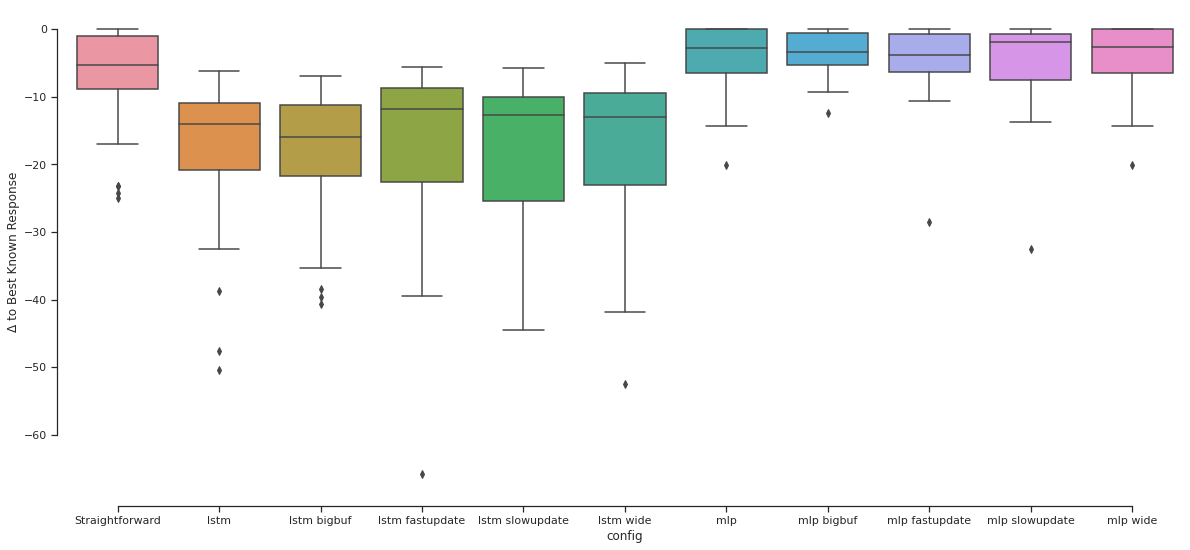

In [377]:
# s = ['_mlp', '_mlp_1', '_mlp_2', '_lstm', '_lstm_1', '_lstm_2', 'Straightforward']
compare_best_responses(master_df)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.imshow(list(q_network.output_layer.parameters())[0].data)
plt.colorbar()

In [419]:
with open('/shared/outputs/feb5_large/lstm/best_responses/checkpoint_50000_br_1_lstm.pkl', 'rb') as f:
    lstm = pickle.load(f)
with open('/shared/outputs/feb5_large/lstm/best_responses/checkpoint_50000_br_1_lstm_wide.pkl', 'rb') as f:
    lstm_wide = pickle.load(f)

In [420]:
for k,v in lstm['agent'].items():
    print((lstm_wide['agent'][k] == v).sum() / v.numel())

tensor(0.8379, device='cuda:0')
tensor(0.9562, device='cuda:0')
tensor(0.8535, device='cuda:0')
tensor(0.8613, device='cuda:0')
tensor(0.5411, device='cuda:0')
tensor(0., device='cuda:0')


In [400]:
for k,v in lstm['agent'].items():
    try:
        print(k, v[:5, :5])
    except:
        pass

model.0._weight tensor([[-0.0738,  0.0251, -0.0180,  0.0524,  0.0456],
        [-0.1627,  0.1003,  0.1378, -0.0003, -0.1243],
        [-0.1341, -0.0745,  0.0142, -0.0730,  0.0164],
        [-0.0010,  0.0699,  0.1272,  0.0282,  0.1044],
        [-0.1232, -0.1031,  0.0950, -0.0763, -0.0282]], device='cuda:0')
model.1._weight tensor([[ 0.0999, -0.1924, -0.1640,  0.0614,  0.0102],
        [ 0.0173,  0.0019, -0.0849,  0.1276,  0.0400],
        [ 0.1009, -0.0362,  0.1386, -0.0005,  0.0558],
        [-0.0037, -0.0198,  0.0509, -0.0119, -0.1395],
        [-0.0659, -0.1676,  0.1000, -0.0594, -0.0037]], device='cuda:0')


In [401]:
for k,v in lstm_wide['agent'].items():
    try:
        print(k, v[:5, :5])
    except:
        pass

model.0._weight tensor([[-0.0738,  0.0251, -0.0180,  0.0524,  0.0456],
        [-0.1627,  0.1003,  0.1378, -0.0003, -0.1243],
        [-0.1341, -0.0745,  0.0142, -0.0730,  0.0164],
        [-0.0010,  0.0699,  0.1272,  0.0282,  0.1044],
        [-0.1232, -0.1031,  0.0950, -0.0763, -0.0282]], device='cuda:0')
model.1._weight tensor([[ 0.0999, -0.1924, -0.1640,  0.0614,  0.0102],
        [ 0.0173,  0.0019, -0.0849,  0.1276,  0.0400],
        [ 0.1009, -0.0362,  0.1386, -0.0005,  0.0558],
        [-0.0037, -0.0198,  0.0509, -0.0119, -0.1395],
        [-0.0659, -0.1676,  0.1000, -0.0594, -0.0037]], device='cuda:0')
